# Загрузка Pandas и очистка данных

In [844]:
import pandas as pd
from multiprocessing import Pool
import numpy as np
import urllib.request
from bs4 import BeautifulSoup
import requests
import matplotlib as plt
import re
import seaborn as sns

### Функции

In [436]:
def cousine_corr(string):
    '''Функция предназначена для перевода строковой переменной с несколькими кухнями в тип 
    list для дальнейего применения explode например'''

    if str(string) == 'nan':
        return None
    else:
        a = str(string).split(',')
        a = list(map(lambda x: x.replace("'", ""), a))
        a = list(map(lambda x: x.replace("[", ""), a))
        a = list(map(lambda x: x.replace("]", ""), a))
        a = list(map(lambda x: x.replace(" ", ""), a))
    return a


def parcing_fill(price_range, cuisine_style, url):
    '''Функция берет URL тех элементов где данные пропущены в столбце price Range 
    (как показала практивка пропущенные данные в столбце тип кухни предполагают и пропуск в ценовом диапазоне) 
    парсит класс "._2mn01bsa" на сайте tripadvisor которй содержит информацию как о цене, так и о кухне
    выходные данные list со след структурой - [$, Bar, European, Portuguese], где первым обязательно идет цена,
    а потом кухни'''

    if price_range == 0:  # в столбце необходимо заменить все пропуски на 0
        full_url = 'https://www.tripadvisor.com' + str(url)
        r = requests.get(full_url)
        print(r)
        soup = BeautifulSoup(r.text)
        fill_data_raw = soup.select("._2mn01bsa")

        if len(fill_data_raw) != 0:
            fill_data = list(map(lambda x: x.string, fill_data_raw))
            return fill_data
        else:
            return 0  # возвращаем 0 если на сайте нет информации
    else:
        return None  # возвращаем 0 если в изначальных данных данные присутствуют


def price_fill(price_range, new_column):
    '''Функция которая вытаскивает данные о ценовом промежутке из list вида - [$, Bar, European, Portuguese]
    с учетом того что этого list может не быть и так же что цены там тоже может не быть'''
    if price_range == '0':  # пропуски в нем нулевые
        if new_column[0] == 'None':
            return None
        elif new_column[0] == '0':
            return None
        else:
            if '$' in new_column[0]:
                return new_column[0]
            else:
                return None
    else:
        return price_range


def cuisine_fill(cuisine, new_column):
    '''Функция которая вытаскивает данные о ценовом промежутке из list вида - [$, Bar, European, Portuguese]
    с учетом того что этого list может не быть, что цены на первом месте может не быть, 
    что в исходном датасете эти данные уже могут быть'''

    if cuisine[0] == '0':  # пропуски в нем нулевые
        if new_column[0] == 'None':
            return None
        elif new_column[0] == '0':
            return None
        else:
            if '$' in new_column[0]:
                if len(new_column) > 1:
                    return new_column[1:]
                else:
                    return None
            else:
                return None
    else:
        return cuisine


def pr_range_clean(x):
    '''т.к. после парсинга появились разные одинаковые значения $$ - $$$ и $$-$$$, их нужно привести к общему виду'''
    if (str(x) == 'None') | (str(x) == 'nan'):
        return None
    else:
        x = x.replace(" ", "")
        return x


def vegan(cusine_list):
    '''функция создания признака - есть ли еда для веганов'''

    if cusine_list == None:
        return 0
    if ('VegetarianFriendly' in cusine_list) | ('VeganOptions' in cusine_list):
        return 1
    else:
        return 0


def healthy(cusine_list):
    '''функция создания признака - есть ли "здоровая"'''

    if cusine_list == None:
        return 0
    if ('GlutenFreeOptions' in cusine_list) | ('Healthy' in cusine_list):
        return 1
    else:
        return 0


def alcohol(cusine_list):
    '''функция создания признака - есть ли упоминание алкоголя'''

    if cusine_list == None:
        return 0
    if ('Bar' in cusine_list) | ('Pub' in cusine_list) | ('WineBar' in cusine_list) | ('BrewPub' in cusine_list) | ('Beerrestaurants' in cusine_list):
        return 1
    else:
        return 0


def fastfood(cusine_list):
    '''функция создания признака - еда относится к быстрой уличной еде'''

    if cusine_list == None:
        return 0
    if ('FastFood' in cusine_list) | ('StreetFood' in cusine_list) | ('QuickBites' in cusine_list):
        return 1
    else:
        return 0


def pizza(cusine_list):
    '''функция определяет пиццерия это или нет'''
    if cusine_list == None:
        return 0
    if ('Pizza' in cusine_list):
        return 1
    else:
        return 0


def italian_cuisine(cusine_list):
    '''функция определяет пиццерия это или нет'''
    if cusine_list == None:
        return 0
    if ('Pizza' in cusine_list) | ('Italian' in cusine_list) | ('Lazio' in cusine_list) | ('Romana' in cusine_list) | ('Sicilian' in cusine_list):
        return 1
    else:
        return 0


def country_data(city):
    '''функция позволяет исходя из города возвращает страну в которой в которой находится, 
       уровень счастья за 2016 год в стране и количество туристов в 2017 году
       по данным крупной статистики unwto и уровень ВВП'''

    # можно такжп это было сделать более элегантно - нацти basis set или информацию (Википедия например)
    # где-то в интернете и найти все необходимые соответстия,
    # но для данного датасета c учетом малого опыта в целом руками было быстрее.

    if city in ['Paris', 'Lyon']:
        country = 'France'
        happines = 6.442
        untwo = 82700
        gdp = 48261
        return country, happines, untwo, gdp

    if city in ['Stockholm']:
        country = 'Sweden'
        happines = 7.314
        untwo = 6559
        gdp = 54130
        return country, happines, untwo, gdp

    if city in ['London', 'Edinburgh']:
        country = 'UK'
        happines = 6.714
        untwo = 35814
        gdp = 47439
        return country, happines, untwo, gdp

    if city in ['Berlin', 'Munich', 'Hamburg']:
        country = 'Germany'
        happines = 6.951
        untwo = 35595
        gdp = 55059

        return country, happines, untwo, gdp

    if city in ['Oporto', 'Lisbon']:
        country = 'Portugal'
        happines = 5.195
        untwo = 18200
        gdp = 34830
        return country, happines, untwo, gdp

    if city in ['Milan', 'Rome']:
        country = 'Italy'
        happines = 6.000
        untwo = 52372
        gdp = 43167
        return country, happines, untwo, gdp

    if city in ['Bratislava']:
        country = 'Slovakia'
        happines = 6.098
        untwo = 5415
        gdp = 32859
        return country, happines, untwo, gdp

    if city in ['Vienna']:
        country = 'Austria'
        happines = 7.139
        untwo = 28121
        gdp = 56741
        return country, happines, untwo, gdp

    if city in ['Barcelona', 'Madrid']:
        country = 'Spain'
        happines = 6.310
        untwo = 75315
        gdp = 41608
        return country, happines, untwo, gdp

    if city in ['Dublin']:
        country = 'Ireland'
        happines = 6.977
        untwo = 10.100
        gdp = 86444
        return country, happines, untwo, gdp

    if city in ['Brussels']:
        country = 'Belgium'
        happines = 6.891
        untwo = 7481
        gdp = 52607
        return country, happines, untwo, gdp

    if city in ['Zurich', 'Geneva']:
        country = 'Switzerland'
        happines = 7.494
        untwo = 10402
        gdp = 70376
        return country, happines, untwo, gdp

    if city in ['Warsaw', 'Krakow']:
        country = 'Poland'
        happines = 5.973
        untwo = 17463
        gdp = 32527
        return country, happines, untwo, gdp

    if city in ['Budapest']:
        country = 'Hungary'
        happines = 5.324
        untwo = 15256
        gdp = 31811
        return country, happines, untwo, gdp

    if city in ['Copenhagen']:
        country = 'Denmark'
        happines = 7.522
        untwo = 10781
        gdp = 57572
        return country, happines, untwo, gdp

    if city in ['Amsterdam']:
        country = 'The Netherlands'
        happines = 7.377
        untwo = 15828
        gdp = 57847
        return country, happines, untwo, gdp

    if city in ['Stockholm']:
        country = 'Sweden'
        happines = 7.284
        untwo = 6559
        gdp = 54130
        return country, happines, untwo, gdp

    if city in ['Prague']:
        country = 'Czech'
        happines = 6.609
        untwo = 12808
        gdp = 41118
        return country, happines, untwo, gdp

    if city in ['Athens']:
        country = 'Greece'
        happines = 5.227
        untwo = 24799
        gdp = 30402
        return country, happines, untwo, gdp

    if city in ['Oslo']:
        country = 'Norway'
        happines = 7.537
        untwo = 5960
        gdp = 64707
        return country, happines, untwo, gdp

    if city in ['Helsinki']:
        country = 'Finland'
        happines = 7.469
        untwo = 2789
        gdp = 49336
        return country, happines, untwo, gdp

    if city in ['Ljubljana']:
        country = 'Slovenia'
        happines = 5.758
        untwo = 3032
        gdp = 39067
        return country, happines, untwo, gdp

    if city in ['Luxembourg']:
        country = 'Luxembourg'
        happines = 6.863
        untwo = 1054
        gdp = 118004
        return country, happines, untwo, gdp


def capital(city):
    '''функция определяет столица или нет'''

    # в целом для более большого набора данных нужно было нормально напарсить эти данные,
    # но не хватило времени

    if city in ['Paris', 'Stockholm', 'London', 'Berlin',
                'Bratislava', 'Vienna', 'Rome', 'Madrid',
                'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
                'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
                'Helsinki', 'Geneva', 'Ljubljana', 'Athens',
                'Luxembourg']:
        return 1
    else:
        return 0


def date_eject(x):
    '''функция позволяет вытаскивать дату в формате год месяц день'''
    pattern = "\d+\/\d+\/\d+"
    return re.findall(pattern, str(x))


def last_comment(x):
    "функция позволяет посчитать дату последнего видимого отыва "
    if len(x) == 2:
        if pd.to_datetime(x[0]) > pd.to_datetime(x[1]):
            return pd.to_datetime(x[0])
        else:
            return pd.to_datetime(x[1])
    elif len(x) == 1:
        return pd.to_datetime(x[0])
    else:
        return None


def date_diff(x):
    if len(x) == 2:
        if pd.to_datetime(x[0]) > pd.to_datetime(x[1]):
            return (pd.to_datetime(x[0])-pd.to_datetime(x[1])).days
        else:
            return (pd.to_datetime(x[1])-pd.to_datetime(x[0])).days
    else:
        return None

In [280]:
df = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
# данные в последствии будут наполняться и обогащаться парсингом сайта trip_advisor 
# поэтому для ускорения после этого шага, данные сохраняться в новый файл и проще будет скачать его
df.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


данные содержат достаточно много ненулевых столбцов. Нулевые - 
+ Price Range - (будем - парсить + заполним наиболлее часто встречающимся или создадим категорию где не указано)
+ Number of reviews (заменим NaN на 0, т.е считаем, что оценка поставлена без письменного отзыва)
+ Cousine style - (будем парсить + из этого столбца вытащим данные таки образом, что нулевые значения не помешают)
+ Reviews также содержит пустые значения (пустые заполним нулями,- отзыв не был написан хотя оценка стоит, либо второй вариант уберем их совсем)

In [5]:
#сначала для дальнейшего удобства в столбце Cousine style сделаем список а не строку
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: cousine_corr(x))


In [6]:
# этот шаг можем не делать. без распаралеливания работает довольно долго. 
#результат этого шага в файле parced_df.csv
df['Price Range'] = df['Price Range'].fillna(0)
df['Cuisine Style'] = df['Cuisine Style'].fillna(0)
df['raw_column'] = df.apply(lambda x: parcing_fill(
    x['Price Range'], x['Cuisine Style'], x['URL_TA']), axis=1)
df.to_csv("parced_df.csv")
df1 = df  # на всякий

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200

In [812]:
df = pd.read_csv('parced_df.csv')
# дополняем кухни и Price range данными после парсинга сайта tripadvisor из колонки raw_column
df['raw_column'] = df['raw_column'].apply(lambda x: cousine_corr(x))
df['price_range'] = df.apply(lambda x: price_fill(x['Price Range'], x['raw_column']), axis = 1)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: cousine_corr(x))
df['cuisine_style'] = df.apply(lambda x: cuisine_fill(x['Cuisine Style'], x['raw_column']), axis = 1) 
df.info() # результатом парсинга стало увеличение на около 5500 -7000 тысяч значений в PRICE_RANGE и Cuisine style
df['sample'] = 1 


# Приведение после загрузок теста к хорошему виду. 
df_test = pd.read_csv('kaggle_task.csv')
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['raw_column'] = None
df_test['Cuisine Style'] = df_test['Cuisine Style'].apply(lambda x: cousine_corr(x))
df_test['price_range'] = df_test['Price Range']
df_test['cuisine_style'] = df_test['Cuisine Style']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         40000 non-null  int64  
 1   Restaurant_id      40000 non-null  object 
 2   City               40000 non-null  object 
 3   Cuisine Style      40000 non-null  object 
 4   Ranking            40000 non-null  float64
 5   Rating             40000 non-null  float64
 6   Price Range        40000 non-null  object 
 7   Number of Reviews  37457 non-null  float64
 8   Reviews            40000 non-null  object 
 9   URL_TA             40000 non-null  object 
 10  ID_TA              40000 non-null  object 
 11  raw_column         13886 non-null  object 
 12  price_range        32545 non-null  object 
 13  cuisine_style      34429 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 4.3+ MB


In [813]:
df.head(5)

,Unnamed: 0,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,raw_column,price_range,cuisine_style,sample
0,0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,None,$$ - $$$,"[European, French, International]",1
1,1,id_1535,Stockholm,[0],1537.0,4.0,0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"[$$-$$$, Asian, Nepali]",$$-$$$,"[Asian, Nepali]",1
2,2,id_352,London,"[Japanese, Sushi, Asian, Grill, VegetarianFrie...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,None,$$$$,"[Japanese, Sushi, Asian, Grill, VegetarianFrie...",1
3,3,id_3456,Berlin,[0],3458.0,5.0,0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,[0],None,None,1
4,4,id_615,Munich,"[German, CentralEuropean, VegetarianFriendly]",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,None,$$ - $$$,"[German, CentralEuropean, VegetarianFriendly]",1


In [814]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,raw_column,price_range,cuisine_style
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0,None,$$ - $$$,"[Bar, Pub]"
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0,None,$$ - $$$,"[European, Scandinavian, GlutenFreeOptions, Ve..."
2,id_2,Edinburgh,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0,None,$$ - $$$,[VegetarianFriendly]
3,id_3,London,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0,None,$$$$,"[Italian, Mediterranean, European, VegetarianF..."
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0,None,$$$$,"[Italian, Mediterranean, European, Seafood, Ve..."


In [815]:
df = df_test.append(df, sort=False).reset_index(drop=True) # объединяем выборки - тест и не тест.
df.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,raw_column,price_range,cuisine_style,Unnamed: 0
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,None,$$ - $$$,"[Bar, Pub]",NaN
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,None,$$ - $$$,"[European, Scandinavian, GlutenFreeOptions, Ve...",NaN
2,id_2,Edinburgh,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,None,$$ - $$$,[VegetarianFriendly],NaN
3,id_3,London,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,None,$$$$,"[Italian, Mediterranean, European, VegetarianF...",NaN
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,None,$$$$,"[Italian, Mediterranean, European, Seafood, Ve...",NaN
5,id_5,Paris,"[French, Cafe, FastFood]",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0,None,$,"[French, Cafe, FastFood]",NaN
6,id_6,Lisbon,"[European, Portuguese]",3704.0,$,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,0.0,None,$,"[European, Portuguese]",NaN
7,id_7,Budapest,None,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,None,NaN,None,NaN
8,id_8,Helsinki,"[European, Scandinavian]",771.0,NaN,2.0,"[['Big group supper', 'Good food but very slow...",/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,0.0,None,NaN,"[European, Scandinavian]",NaN
9,id_9,Stockholm,[Italian],605.0,NaN,13.0,"[['Good food', 'Good pizza'], ['12/02/2017', '...",/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,0.0,None,NaN,[Italian],NaN


## Обогащение данных - шаг 2 (после парсинга) + feature engenering колонок с пропусками.


In [816]:
# Вариант 1 c Number of Reviews  - заполнить нулями.   результат
df['reviews_num'] = df['Number of Reviews'].fillna(df[df['sample'] == 1]['Number of Reviews'].median())
# Вариант 2 c Number of Reviews - убрать из рассмотрения


#df['price_range'] = 
df['price_range'] = df['price_range'].apply(lambda x: pr_range_clean(x))
df['price_range'].value_counts()

$$-$$$    26660
$         10504
$$$$       1906
Name: price_range, dtype: int64

In [817]:
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
# возможно это дата данные отсортированные по занесению в базу данных

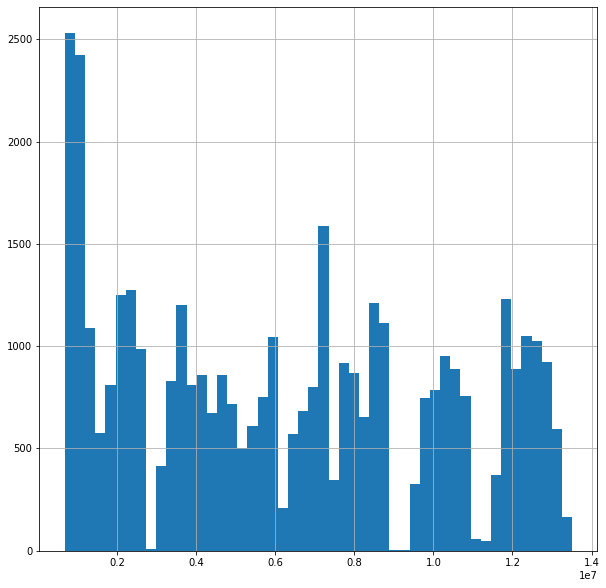

In [818]:
df[df['sample'] == 1]['ID_TA'].hist(bins=50)

In [819]:
# Вариант 1 c price_range  - заполнить самым распространенным значением ($$-$$$ существенно больше), 
# и присвоить значениям от 0 до 2   \\ результат - 
df['price_range_1'] = df['price_range'].fillna(df['price_range'].value_counts().index[0])
price_range_dict_1 = {'$':0,
                      '$$-$$$':1,
                      '$$$$':2,
                     }
df.price_range_1 = df.price_range_1.replace(to_replace = price_range_dict_1)
price_range_dict_2 = {'no':0,
                      '$':1,
                      '$$-$$$':2,
                      '$$$$':3,
                     }
# Вариант 2 c price_range - заполнить нулями и те рестораны у которых не указана цена, 
# сделать отдельной группой и присвоито значения от 0 до 3 \\ результат - 
df['price_range_2'] = df['price_range'].fillna('no')
df.price_range_2 = df.price_range_2.replace(to_replace = price_range_dict_2)
df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,raw_column,price_range,cuisine_style,Unnamed: 0,reviews_num,price_range_1,price_range_2
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,0.0,None,$$-$$$,"[Bar, Pub]",NaN,4.0,1,2
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,0.0,None,$$-$$$,"[European, Scandinavian, GlutenFreeOptions, Ve...",NaN,97.0,1,2
2,id_2,Edinburgh,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,0.0,None,$$-$$$,[VegetarianFriendly],NaN,28.0,1,2
3,id_3,London,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,0.0,None,$$$$,"[Italian, Mediterranean, European, VegetarianF...",NaN,202.0,2,3
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,0.0,None,$$$$,"[Italian, Mediterranean, European, Seafood, Ve...",NaN,162.0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, VegetarianFriendly, VeganOptions, Gl...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,2104414,1,4.5,None,$$-$$$,"[Italian, VegetarianFriendly, VeganOptions, Gl...",39995.0,79.0,1,2
49996,id_6340,Paris,"[French, American, Bar, European, VegetarianFr...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,1800036,1,3.5,None,$$-$$$,"[French, American, Bar, European, VegetarianFr...",39996.0,542.0,1,2
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,947615,1,4.5,"[Japanese, Sushi]",None,"[Japanese, Sushi]",39997.0,4.0,1,0
49998,id_640,Warsaw,"[Polish, European, EasternEuropean, CentralEur...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,1100838,1,4.0,None,$$-$$$,"[Polish, European, EasternEuropean, CentralEur...",39998.0,70.0,1,2


In [820]:
# работа с кухнями - просмотр уникальных значени
df.explode('cuisine_style')['cuisine_style'].value_counts().head(35)

# как видно - чаще всего упоминаются веганские, европейская кухня (выборка европейских ресторанов), 
# Итальянская (вместе с пиццей), а также алкогольные упоминания (бары, vinebar, pub и т.д.), 
# поэтому из них будем делать логичные признаки 

VegetarianFriendly    14828
European              13248
Mediterranean          8234
Italian                7978
VeganOptions           5799
GlutenFreeOptions      5201
Bar                    4387
French                 4342
Asian                  4006
Spanish                3935
Pizza                  3724
Cafe                   3473
Pub                    3246
FastFood               2420
British                2027
International          2016
Japanese               1967
Seafood                1960
CentralEuropean        1780
American               1745
Chinese                1569
Sushi                  1539
Portuguese             1517
Indian                 1377
MiddleEastern          1055
German                  975
Thai                    962
WineBar                 915
Greek                   819
Healthy                 790
Halal                   778
Czech                   770
Steakhouse              765
Fusion                  757
Barbecue                753
Name: cuisine_style,

In [821]:
# Значений для кухонь довольно много + есть пропущенные значения - как вариант убрать этот столбец из анализа,
# но создать отдельные категориальные признаки - веган(да/нет), здоровая(да/нет), бар,винобар(да /нет), 
# фастфуд (да/нет) и разнообразие кухонь - количество кухонь. При этом -  

# вариант 1 для cuisine styles - не использовать столбцы с пропусками \\ результат - 

df['vegan'] = df['cuisine_style'].apply(lambda x: vegan(x))
df['healthy'] = df['cuisine_style'].apply(lambda x: healthy(x))
df['alcohol'] = df['cuisine_style'].apply(lambda x: alcohol(x))
df['fastfood'] = df['cuisine_style'].apply(lambda x: fastfood(x))
df['cuisine_style_raw'] = df['cuisine_style'].fillna('0')
df['cuisine_difference'] = df['cuisine_style_raw'].apply(lambda x: len(x))
df['pizza'] = df['cuisine_style'].apply(lambda x: pizza(x))
df['italian_cuisine'] = df['cuisine_style'].apply(lambda x: italian_cuisine(x))


df

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,price_range_1,price_range_2,vegan,healthy,alcohol,fastfood,cuisine_style_raw,cuisine_difference,pizza,italian_cuisine
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,...,1,2,0,0,1,0,"[Bar, Pub]",2,0,0
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,...,1,2,1,1,0,0,"[European, Scandinavian, GlutenFreeOptions, Ve...",5,0,0
2,id_2,Edinburgh,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,...,1,2,1,0,0,0,[VegetarianFriendly],1,0,0
3,id_3,London,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,...,2,3,1,1,0,0,"[Italian, Mediterranean, European, VegetarianF...",5,0,1
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,...,2,3,1,1,0,0,"[Italian, Mediterranean, European, Seafood, Ve...",6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, VegetarianFriendly, VeganOptions, Gl...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,2104414,1,...,1,2,1,1,0,0,"[Italian, VegetarianFriendly, VeganOptions, Gl...",4,0,1
49996,id_6340,Paris,"[French, American, Bar, European, VegetarianFr...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,1800036,1,...,1,2,1,0,1,0,"[French, American, Bar, European, VegetarianFr...",5,0,0
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,947615,1,...,1,0,0,0,0,0,"[Japanese, Sushi]",2,0,0
49998,id_640,Warsaw,"[Polish, European, EasternEuropean, CentralEur...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,1100838,1,...,1,2,1,0,0,0,"[Polish, European, EasternEuropean, CentralEur...",5,0,0


## Feature engeneering ненулевых параметров

In [822]:
# работаем сс столбцом город - добавим информацию о том столица этот город или нет, а также
# уровень счастья жителей страны, количество туристов в 2017 году
# по данным крупной статистики unwto и уровень ВВП

df['capital'] = df.City.apply(lambda x: capital(x))
df['raw_col'] = df.City.apply(lambda x: country_data(x))
df['happines'] = df.raw_col.apply(lambda x: x[1])
df['untwo'] = df.raw_col.apply(lambda x: x[2])
df['gdp'] = df.raw_col.apply(lambda x: x[3])

city_population_dict = {'Paris': 2148, 
                        'Helsinki': 632, 
                        'Edinburgh': 482, 
                        'London': 8982, 
                        'Bratislava': 424, 
                        'Lisbon': 505,
                        'Budapest': 1752, 
                        'Stockholm': 976, 
                        'Rome': 2873, 
                        'Milan': 1352, 
                        'Munich': 1472, 
                        'Hamburg': 1845,
                        'Prague': 1309, 
                        'Vienna': 1897, 
                        'Dublin': 1388, 
                        'Barcelona': 1636, 
                        'Brussels': 174, 
                        'Madrid': 6642,
                        'Oslo': 681, 
                        'Amsterdam': 822, 
                        'Berlin': 3769, 
                        'Lyon': 507, 
                        'Athens': 664, 
                        'Warsaw': 1708,       
                        'Oporto': 214, 
                        'Krakow': 779, 
                        'Copenhagen': 602, 
                        'Luxembourg': 613, 
                        'Zurich': 403, 
                        'Geneva': 500,
                        'Ljubljana': 280
                       }
df['population'] = df.City.replace(to_replace = city_population_dict)
df
# в целом я понимаю что если совсем чуть чуть изменить dataset, 
# то будет добавься только один город и модель слетит. но у меня небыло времени спарсить результаты.
# Пытался через API, в них пока не разобрался. Отпарсить через википедию - не получилось

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,cuisine_style_raw,cuisine_difference,pizza,italian_cuisine,capital,raw_col,happines,untwo,gdp,population
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,10746918,0,...,"[Bar, Pub]",2,0,0,1,"(France, 6.442, 82700, 48261)",6.442,82700.0,48261,2148
1,id_1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,6674944,0,...,"[European, Scandinavian, GlutenFreeOptions, Ve...",5,0,0,1,"(Finland, 7.469, 2789, 49336)",7.469,2789.0,49336,632
2,id_2,Edinburgh,[VegetarianFriendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,13129638,0,...,[VegetarianFriendly],1,0,0,0,"(UK, 6.714, 35814, 47439)",6.714,35814.0,47439,482
3,id_3,London,"[Italian, Mediterranean, European, VegetarianF...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,680417,0,...,"[Italian, Mediterranean, European, VegetarianF...",5,0,1,1,"(UK, 6.714, 35814, 47439)",6.714,35814.0,47439,8982
4,id_4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,1112354,0,...,"[Italian, Mediterranean, European, Seafood, Ve...",6,0,1,1,"(Slovakia, 6.098, 5415, 32859)",6.098,5415.0,32859,424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"[Italian, VegetarianFriendly, VeganOptions, Gl...",500.0,$$ - $$$,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,2104414,1,...,"[Italian, VegetarianFriendly, VeganOptions, Gl...",4,0,1,0,"(Italy, 6.0, 52372, 43167)",6.000,52372.0,43167,1352
49996,id_6340,Paris,"[French, American, Bar, European, VegetarianFr...",6341.0,$$ - $$$,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,1800036,1,...,"[French, American, Bar, European, VegetarianFr...",5,0,0,1,"(France, 6.442, 82700, 48261)",6.442,82700.0,48261,2148
49997,id_1649,Stockholm,"[Japanese, Sushi]",1652.0,0,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,947615,1,...,"[Japanese, Sushi]",2,0,0,1,"(Sweden, 7.314, 6559, 54130)",7.314,6559.0,54130,976
49998,id_640,Warsaw,"[Polish, European, EasternEuropean, CentralEur...",641.0,$$ - $$$,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,1100838,1,...,"[Polish, European, EasternEuropean, CentralEur...",5,0,0,1,"(Poland, 5.973, 17463, 32527)",5.973,17463.0,32527,1708


In [823]:
#new - ranking отнормированный ranking по 
City_list = df['City'].unique()

Max_num_rest_list = list(map(lambda x: df[df.City == x]['Ranking'].max(), City_list))
#a[list(b).index('Paris')]

df['max_num_rest'] = df['City'].apply(lambda x: Max_num_rest_list[list(City_list).index(x)])
df['new_ranking'] = df['Ranking']/df['max_num_rest']*1000 


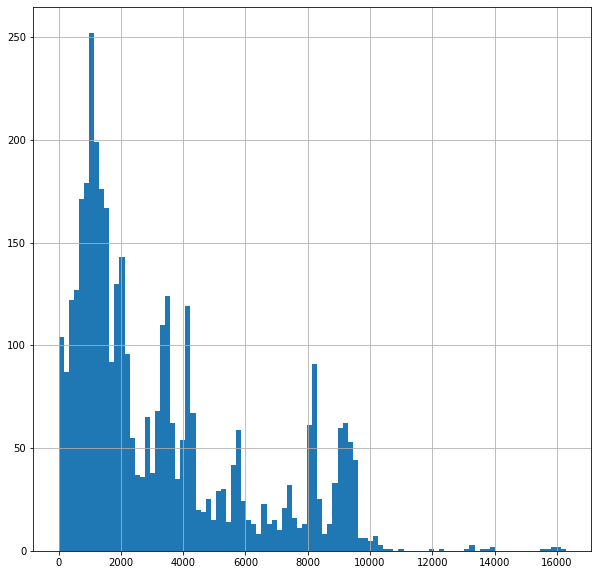

In [824]:
df[df['sample'] == 1]['Ranking'][df['Rating'] == 5].hist(bins=100)
# скорее всего при рейтинге 5 наши данные Ranking имеют выбросы (такие низкорейтиноговые рестораны 
# не могут иметь оценку 5 - это может быть ошибка - или слишком мало отзывов 
# - можно попробовать их убрать из данных = df2 будет)

In [825]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Restaurant_id       50000 non-null  object 
 1   City                50000 non-null  object 
 2   Cuisine Style       47693 non-null  object 
 3   Ranking             50000 non-null  float64
 4   Price Range         46525 non-null  object 
 5   Number of Reviews   46800 non-null  float64
 6   Reviews             49998 non-null  object 
 7   URL_TA              50000 non-null  object 
 8   ID_TA               50000 non-null  int64  
 9   sample              50000 non-null  int64  
 10  Rating              50000 non-null  float64
 11  raw_column          13886 non-null  object 
 12  price_range         39070 non-null  object 
 13  cuisine_style       42122 non-null  object 
 14  Unnamed: 0          40000 non-null  float64
 15  reviews_num         50000 non-null  float64
 16  pric

In [826]:
# Удаляем ненужные столбцы

del df['Restaurant_id']
del df['Cuisine Style']
del df['Price Range']
del df['Number of Reviews']
del df['Unnamed: 0']
del df['raw_column'] 
del df['price_range'] 
del df['cuisine_style']
del df['URL_TA']
del df['raw_col']
del df['cuisine_style_raw']

In [827]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                50000 non-null  object 
 1   Ranking             50000 non-null  float64
 2   Reviews             49998 non-null  object 
 3   ID_TA               50000 non-null  int64  
 4   sample              50000 non-null  int64  
 5   Rating              50000 non-null  float64
 6   reviews_num         50000 non-null  float64
 7   price_range_1       50000 non-null  int64  
 8   price_range_2       50000 non-null  int64  
 9   vegan               50000 non-null  int64  
 10  healthy             50000 non-null  int64  
 11  alcohol             50000 non-null  int64  
 12  fastfood            50000 non-null  int64  
 13  cuisine_difference  50000 non-null  int64  
 14  pizza               50000 non-null  int64  
 15  italian_cuisine     50000 non-null  int64  
 16  capi

In [828]:
# работа со столбцом Reviews - 

df['dates'] = df['Reviews'].apply(lambda x: date_eject(x))
df['last_date'] = df['dates'].apply(lambda x: last_comment(x)) #расчитали дату последнего видимого комента на сайте
# в этом столбце last_date - формат дата и куча пропусков аоэтому - два варианта представления. 
# вариант 1 - отнормировать на максимальный и заполнить пропуски нулями
df['last_date_dif'] = (df['last_date'].max() - df['last_date']).dt.days # вместо того что бы отображать 
df['last_date_dif'] = df['last_date_dif'].fillna(0)

# вариант 2 - оставить только года, проруски заполнить нулями
df['last_date'] = df['last_date'].dt.year
df['last_date'] = df['last_date'].fillna(0)

df['date_diff'] = df['dates'].apply(lambda x: date_diff(x))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                50000 non-null  object 
 1   Ranking             50000 non-null  float64
 2   Reviews             49998 non-null  object 
 3   ID_TA               50000 non-null  int64  
 4   sample              50000 non-null  int64  
 5   Rating              50000 non-null  float64
 6   reviews_num         50000 non-null  float64
 7   price_range_1       50000 non-null  int64  
 8   price_range_2       50000 non-null  int64  
 9   vegan               50000 non-null  int64  
 10  healthy             50000 non-null  int64  
 11  alcohol             50000 non-null  int64  
 12  fastfood            50000 non-null  int64  
 13  cuisine_difference  50000 non-null  int64  
 14  pizza               50000 non-null  int64  
 15  italian_cuisine     50000 non-null  int64  
 16  capi

In [829]:
del df['dates']
del df['Reviews']

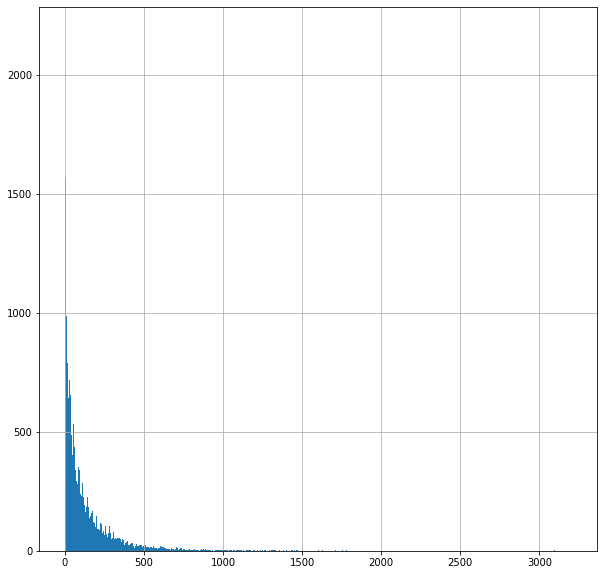

In [830]:
df[df['sample'] == 1]['date_diff'].hist(bins=900)
#с учетом того что у этого признака (разница в днях между комментариями) много нулевых значений получилось - 
# попробуем заполнить и макс значением и нулями. и посмотрим что лучше
df['date_diff_1'] = df['date_diff'].fillna(0)
df['date_diff'] = df['date_diff'].fillna(df[df['sample'] == 1]['date_diff'].dropna().max())

Таким образом получили датафрейм без нулевых значений - разобьем на 3 df - в которых - 
+ Cities не участвует, не убираем выбросы значений рейтинга = 5 и низкого ранинга (df1)
+ Cities не участвует, убираем выбросы значений рейтинга = 5 и низкого ранинга (df2)
+ Cities через dummies, не убираем выбросы значений рейтинга = 5 и низкого ранинга (df3)
+ Cities через dummies, убираем выбросы значений рейтинга = 5 и низкого ранинга (df4)

Для каждого df - проверяем различные параметры заполнения - 
+ price_range_1/price_range_2
+ last_date/last_date_dif
+ date_diff/date_diff_1
+ Ranking/new_ranking

In [831]:
df1 = df[df['sample'] == 1]

df2 = df
df2 = df2[df['sample'] == 1][(df['Ranking'] < 10000) | (df['Rating'] != 5)]

df3 = pd.get_dummies(df[df['sample'] == 1], columns = ['City'], dummy_na = True)

df4 = pd.get_dummies(df, columns = ['City'], dummy_na = True)
df4 = df4[df['sample'] == 1][(df['Ranking'] < 10000) | (df['Rating'] != 5)]

C:\Users\320071926\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\320071926\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [832]:
df3

,Ranking,ID_TA,sample,Rating,reviews_num,price_range_1,price_range_2,vegan,healthy,alcohol,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
10000,5570.0,1912643,1,3.5,194.0,1,2,0,0,0,...,0,0,1,0,0,0,0,0,0,0
10001,1537.0,7992032,1,4.0,10.0,1,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10002,353.0,8632781,1,4.5,688.0,2,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10003,3458.0,1358776,1,5.0,3.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,621.0,6864963,1,4.0,84.0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,500.0,2104414,1,4.5,79.0,1,2,1,1,0,...,0,0,0,0,0,0,0,0,0,0
49996,6341.0,1800036,1,3.5,542.0,1,2,1,0,1,...,0,0,1,0,0,0,0,0,0,0
49997,1652.0,947615,1,4.5,4.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49998,641.0,1100838,1,4.0,70.0,1,2,1,0,0,...,0,0,0,0,0,0,0,1,0,0


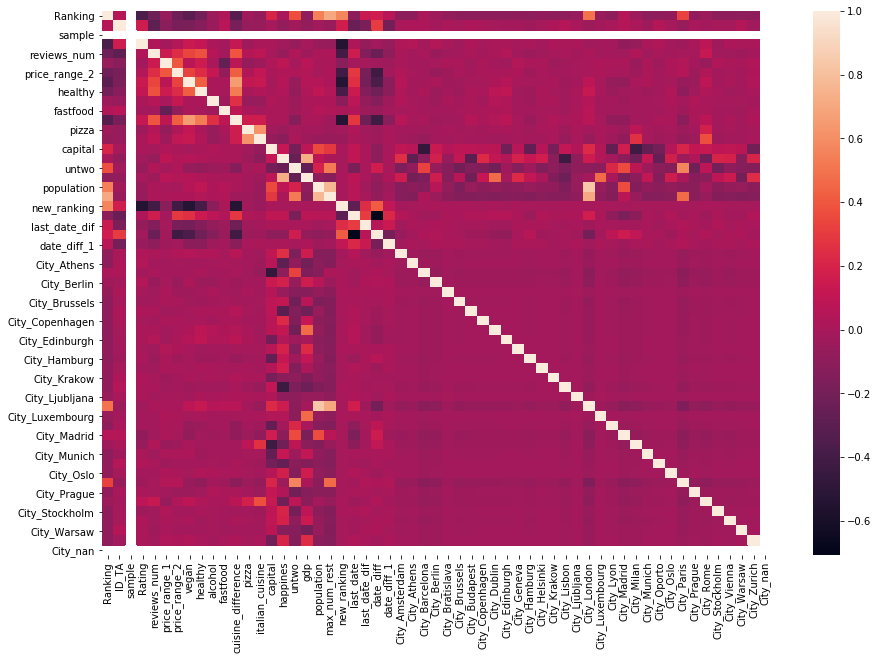

In [846]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df3.corr(),)

# наибольшие корреляции наблюдаются с параметрами new_ranking и колличеством отзывов. 
# наши городские признаки коррелируют со значениями популяции и данных которых вытащили по странам,
# возможно не нужно было так много информации такой. 

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [833]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df3[df3['sample'] == 1].drop(['Rating', 'price_range_1', 'last_date', 'date_diff', 'Ranking', 'sample'],  axis = 1)
y = df3[df3['sample'] == 1]['Rating']

In [834]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [835]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [836]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [837]:
# Создаём модель
RANDOM_SEED = 42
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


In [838]:
b = np.modf(y_pred)
a = b[0]
c = b[1]
print(a+c)
a[a <= 0.25] = 0
a[a >= 0.75] = 1
a[(a > 0.25) & (a < 0.75)] = 0.5
y_pred = a + c
y_pred

[4.56  4.91  4.16  ... 4.42  4.335 4.475]


array([4.5, 5. , 4. , ..., 4.5, 4.5, 4.5])

In [839]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1694


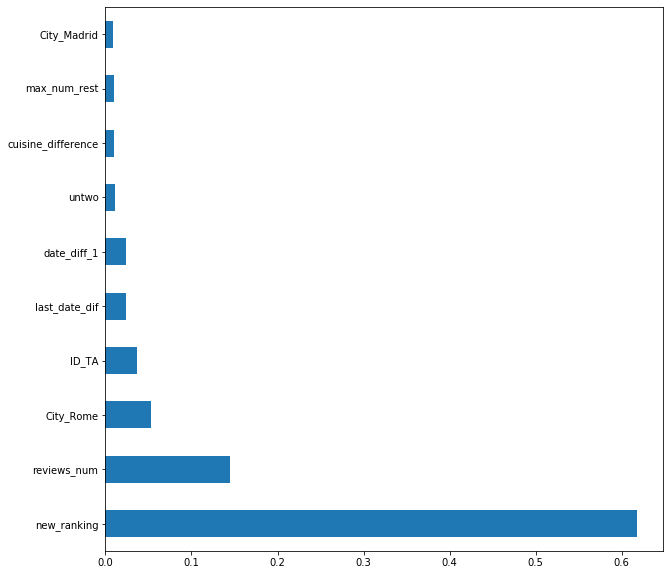

In [841]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

По итогу всего - самый важный параметр отнормированный new_ranking - рейтинг ресторанов он и определяет точность модели - по факту единственное улучшение которое было сделано по сравнению с отбрасыванием всех нулевых значений - это расширение статистики + округление итогового prediction. 

Парсинг нужно было делать не прпущенных значений, а доп признаков по городам например + скорее всего как то по другому обогатить reviews_num, т.к. он имеет большое значение. 

Идея которую хочу еще воплотить (совсем нет времени на парсинг данных) - вытащить из tripadvisor адрес а затем найти на гугл картах параметр - удаленность от центра города. Мне кажется может сработать. Не успел, но хочу попробовать.

In [847]:
df = pd.get_dummies(df, columns = ['City'], dummy_na = True)

In [869]:
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample', 'price_range_1', 'last_date', 'date_diff', 'Ranking', 'Rating'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating', 'price_range_1', 'last_date', 'date_diff', 'Ranking'], axis=1)

In [871]:
test_data.shape

(10000, 51)

In [872]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [876]:
# Создаём модель
RANDOM_SEED = 42
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X, y)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(test_data)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [877]:
b = np.modf(y_pred)
a = b[0]
c = b[1]
print(a+c)
a[a <= 0.25] = 0
a[a >= 0.75] = 1
a[(a > 0.25) & (a < 0.75)] = 0.5
y_pred = a + c

[3.07  4.155 4.395 ... 2.995 4.175 4.23 ]


In [878]:
y_pred

array([3. , 4. , 4.5, ..., 3. , 4. , 4. ])

In [879]:
sample_submission['Rating'] = y_pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.0
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
